In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import time
from keras.layers import LSTM
from tensorflow import keras


강의내용과 같이 주식가격을 예측하는 RNN기반 회귀분석기(regressor)를 LSTM을 이용하여 구현하고 학습하여 아래와 같이 5일 후의 실제 장중최고가와 예측가를 비교할 수 있는 그래프를 10여개의 샘플에 대해 출력하여 ipynb파일을 제출하시오.

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/실전딥러닝2023/AAPL.csv")
df

,Date,High,Low,Open,Close,Volume,Adj Close
0,2006-01-03,2.669643,2.580357,2.585000,2.669643,807234400.0,2.284267
1,2006-01-04,2.713571,2.660714,2.683214,2.677500,619603600.0,2.290990
2,2006-01-05,2.675000,2.633929,2.672500,2.656429,449422400.0,2.272961
3,2006-01-06,2.739286,2.662500,2.687500,2.725000,704457600.0,2.331634
4,2006-01-09,2.757143,2.705000,2.740357,2.716071,675040800.0,2.323994
...,...,...,...,...,...,...,...
3744,2020-11-16,120.989998,118.150002,118.919998,120.300003,91183000.0,120.300003
3745,2020-11-17,120.669998,118.959999,119.550003,119.389999,74271000.0,119.389999
3746,2020-11-18,119.820000,118.000000,118.610001,118.029999,76322100.0,118.029999
3747,2020-11-19,119.059998,116.809998,117.589996,118.639999,74113000.0,118.639999


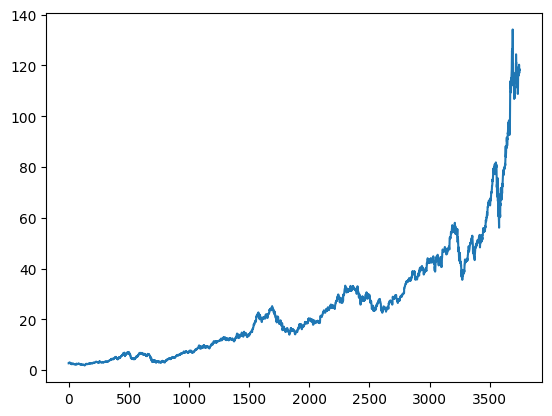

In [ ]:
plt.plot(df['Close'])

In [ ]:
split = 0.75
train_split = int(split*int(df.shape[0]))
seq_len = 60
future = 5
lr = 0.001
epochs = 50


(2811, 5)

In [ ]:

def normalize(x,y):
  mean =tf.reduce_mean(x,axis =1)
  std = tf.math.reduce_std(x,axis=1)
  return (x-tf.expand_dims(mean,axis=1))/tf.expand_dims(std,axis=1),(y-mean[:,0])/std[:,0]


In [ ]:
items = ['AAPL','IBM','INTC','AMD','MSFT']
items_dfs = [pd.read_csv(f"/content/drive/MyDrive/Colab Notebooks/실전딥러닝2023/{i}.csv") for i in items]
def preprocessing_datasets(df):
  features = df[['High', 'Low', 'Open', 'Close', 'Volume']]
  train_data = features.loc[0:train_split -1]
  val_data = features.loc[train_split:]
  x_train = train_data.values
  pred_start = seq_len +future
  pred_end = pred_start +train_split
  y_train = features.iloc[pred_start:pred_end][['High']].values

  x_test = val_data.values[:-seq_len - future -1]
  y_test = features.iloc[train_split+seq_len+future+1:][['High']].values

  dataset_train = keras.preprocessing.timeseries_dataset_from_array(
      x_train,
      y_train,
      sequence_length = seq_len,
      batch_size =1,
  )
  dataset_test = keras.preprocessing.timeseries_dataset_from_array(
      x_test,
      y_test,
      sequence_length = seq_len,
      batch_size =1,
  )
  return dataset_train.map(normalize),dataset_test.map(normalize)



In [ ]:
train_datasets, test_datasets = zip(*[preprocessing_datasets(df) for df in items_dfs])

In [ ]:
x_train,y_train = [],[]
for dataset in train_datasets:
  _x_train, _y_train = zip(*dataset.map(normalize).as_numpy_iterator())
  x_train.extend(_x_train)
  y_train.extend(_y_train)
x_train,y_train = np.array(x_train),  np.array(y_train)

x_train,y_train = x_train.squeeze(axis =1 ),y_train.squeeze(axis =1 )

x_test,y_test = [],[]
for dataset in test_datasets:
  _x_test, _y_test = zip(*dataset.map(normalize).as_numpy_iterator())
  x_test.extend(_x_test)
  y_test.extend(_y_test)
x_test,y_test = np.array(x_test),  np.array(y_test)

x_test,y_test = x_test.squeeze(axis =1 ),y_test.squeeze(axis =1 )

In [ ]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(13760, 60, 5)
(13760, 1)
(4065, 60, 5)
(4065, 1)


In [ ]:
np.savez('stockprice5',x_train=x_train, y_train= y_train, x_test = x_test, y_test = y_test)